# Development - Pasiphae survey: Motion constraints for WALOP-S

In [1]:
from astropy.coordinates import AltAz, Angle, EarthLocation, SkyCoord
from astropy.time import Time
import astropy.units as u
from math import copysign
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cmasher as cms

In [2]:
plt.style.use('file:///home/skiehl/Projects/Python/Scripts/mypackages/mplstyles/notebook.mplstyle')
plt.rcParams.update({
    'figure.figsize': [7, 7],
    'lines.linestyle': '-',
    'lines.linewidth': 2,
    })

n_colors = 3
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[cms.apple_r(i/n_colors) for i in range(1, n_colors+1)])

## The algorithm

https://en.wikipedia.org/wiki/Point_in_polygon gives a useful discussion about the problem and solutions. I tried the *ray casting* algorithm and a primitive version of the *winding number* algorithm. Both approaches failed in various cases. The algorithms are valid, however, the implementations I tried failed in specific special conditions. Then I found this approach 
https://web.archive.org/web/20130126163405/http://geomalgorithms.com/a03-_inclusion.html through the references on the Wikipedia page. This is what I am going to use, because it works and is much simpler and faster than the other approaches.

**The winding number algorithm:**

1. We iterate through all segments of the polygon. For each segment we test,
    1. if a horizontal ray from the points to the right passes the segment and the segment is pointing up the winding number is increased by `1`,
    1. if a horizontal ray from the points to the right passes the segment and the segment is pointing down the winding number is decreased by `1`.
1. if the winding number is `0` the point is outside of the polygon, inside otherwise.

The line segment $(q_0, q_1)$ is pointing up and the point $p$ lies on a height inbetween if $y_{q_0} \leq y_p < y_{q_1}$. 
The line segment $(q_0, q_1)$ is pointing down and the point $p$ lies on a height inbetween if $y_{q_1} \leq y_p < y_{q_0}$. 

Whether the point $p$ is located on the left or right of the line segment $(q_0, q_1)$ can be calculated through the orientation:

$O(p, q_0, q_1) = (y_{q_1} - y_{q_0}) (x_{q_0} - x_p) - (y_{q_0} - y_p) (x_{q_1} - x_{q_0})$.

If $O(p, q_0, q_1)>0$ the points run in mathematically positive orientation (counter-clockwise), if $O(p, q_0, q_1)<0$ the points run in mathematically negative orientation (clockwise), if $O(p, q_0, q_1)=0$ the points are all located on a straight line. Depending on whether the segment is pointing up or down we need to ensure that the point is on the left or right.

First, we implement the `orientation` function:

In [3]:
def orientation(p, q0, q1):
    return np.sign((q1[0] - q0[0]) * (p[1] - q0[1]) - (p[0] - q0[0]) * (q1[1] - q0[1]))

Second, we implement the `crossing` function that returns `+1` for case `A` above, `-1` for case `B`, or `0` otherwise, which is the case when the line segment would not be crossed by the ray extending from the point or when the line segment is horizontal:

In [4]:
def crossing(p, q0, q1):
    p_heq_q0 = q0[1] <= p[1]
    p_heq_q1 = q1[1] <= p[1]
    p_left = orientation(p, q0, q1)
    
    if p_heq_q0 and ~p_heq_q1 and p_left > 0:
        cross = +1
    elif ~p_heq_q0 and p_heq_q1 and p_left < 0:
        cross = -1
    else:
        cross = 0
    
    return cross

Demonstration of both functions:

1
1


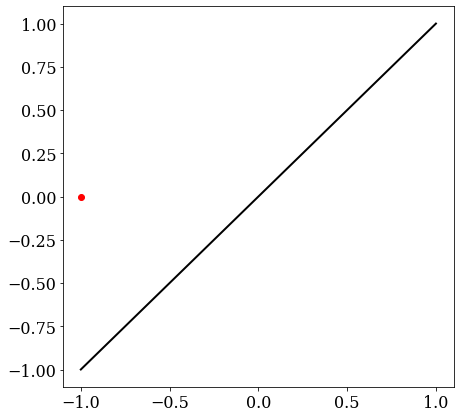

In [5]:
p = (-1, 0)
q0 = (-1, -1)
q1 = (1, 1)

plt.plot(p[0], p[1], marker='o', color='r')
plt.plot([q0[0], q1[0]], [q0[1], q1[1]], linestyle='-', color='k')

print(orientation(p, q0, q1))
print(crossing(p, q0, q1))

Lastly, we define the `inside_polygon` function that returns `True` only if the point is within the polygon:

In [6]:
def inside_polygon(point, polygon):
    polygon = np.array(polygon + [polygon[0]])
    
    winding_number = 0
    
    for q0, q1 in zip(polygon[0:-1], polygon[1:]):
        winding_number += crossing(point, q0, q1)
    
    return winding_number > 0

**Note:** Points on left boundaries or lower boundaries would be considered inside, on the other bounds outside. The definition is reasonably chosen this way, because if we had touching squares a point would always be associated with only one square. This is irrelevant in our context. However, there is no simple way of rewriting the functions to include or exclude all points on the boundaries. I.e. replacing all *smaller/larger than or equal to* with *smaller/larger than* in `crossing` does not do the job; this will fail in various situations. There is no harm including some boundaries and exclude others. This is an infinitely small line of distinction. Therefore, I will keep the algorithm as it is.

### Tests

Demonstration of the `inside_polygon` function:

True

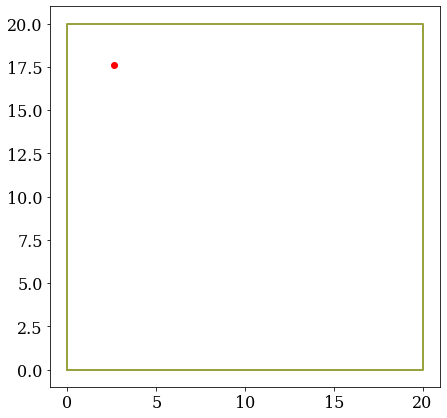

In [7]:
polygon = [(0, 0), (20, 0), (20, 20), (0, 20)]
point = (np.random.uniform(-5, 25), np.random.uniform(-5, 25))

polygon_ar = np.array(polygon + [polygon[0]])
plt.plot(polygon_ar[:,0], polygon_ar[:,1], linestyle='-')
plt.plot(point[0], point[1], marker='o', color='red')

inside_polygon(point, polygon)

False

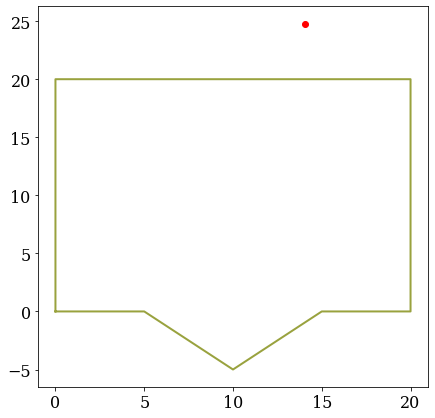

In [8]:
polygon = [(0, 0), (5, 0), (10, -5), (15, 0), (20, 0), (20, 20), (0, 20)]
point = (np.random.uniform(-5, 25), np.random.uniform(-5, 25))

polygon_ar = np.array(polygon + [polygon[0]])
plt.plot(polygon_ar[:,0], polygon_ar[:,1], linestyle='-')
plt.plot(point[0], point[1], marker='o', color='red')

inside_polygon(point, polygon)

True

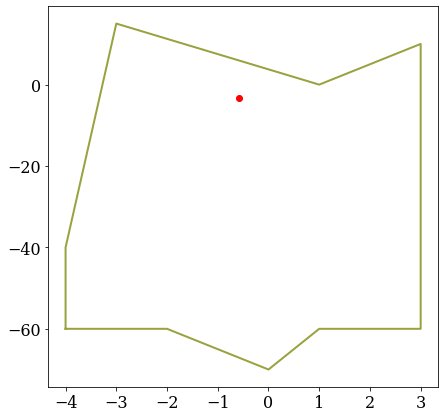

In [9]:
polygon = [(-4, -60), (-2, -60), (0, -70), (1, -60), (3, -60), (3, 10), (1, 0), (-3, 15), (-4, -40)]
point = (np.random.uniform(-4, 4), np.random.uniform(-70, 15))

polygon_ar = np.array(polygon + [polygon[0]])
plt.plot(polygon_ar[:,0], polygon_ar[:,1], linestyle='-')
plt.plot(point[0], point[1], marker='o', color='red')

inside_polygon(point, polygon)

## Test implementation of the constraint class

In [10]:
%load_ext autoreload
%autoreload 2

The constraint is implemented in the `PolyHADecLimit` class in the `constraints` module. The `PolyHADecLimit` class is vectorized over all input source coordinates, using `numpy`. Thus the class methods are not simply copies of the functions above. Load the class and create an instance:

In [11]:
from constraints import PolyHADecLimit

In [12]:
polygon = [(-4, -60), (-2, -60), (0, -70), (1, -60), (3, -60), (3, 10), (1, 0), (-3, 15), (-4, -40)]
constraint = PolyHADecLimit(polygon)

Using the Southerland location for a test:

In [13]:
lat = Angle('-32:22:46 deg')
lon = Angle('20:48:38.5 deg')
height = 1798.
loc = EarthLocation(lat=lat, lon=lon, height=height)

Create a grid of hourangles and declinations (the actual RA of the target source does not matter, because I create 24 hours of hourangles and wrap them into the range from -12 to 12). So, the creation of hourangles is somewhat over complicated and it is acutally just needed for the plotting. The `get()` method of the `PolyHADecLimit` class requires source coordinates as `astropy.coordinates.SkyCoord` and an `astropy.coordinates.builtin_frames.altaz.AltAz` frame that contains the location and time.

In [14]:
duration = np.arange(0, 24., 0.5) * u.h
time = Time('2022-08-01T00:00:00.0', location=loc) + duration
frame = AltAz(obstime=time, location=loc)
#lst = time.sidereal_time('apparent')
lst = frame.obstime.sidereal_time('apparent')

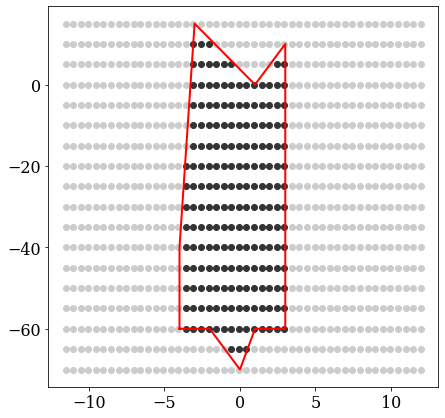

In [15]:
for dec in np.arange(-70, 20, 5):
    source_coord = SkyCoord('15:00:00', dec, unit=('hourangle', 'deg'))
    is_inside = constraint.get(source_coord, frame)
    hourangle = (source_coord.ra - lst).hourangle
    hourangle = (12. + hourangle) % 24. - 12.
    dec = np.ones(hourangle.size) * source_coord.dec.deg
    
    plt.plot(hourangle[is_inside], dec[is_inside], marker='o', color='0.2', ls='None', zorder=0)
    plt.plot(hourangle[~is_inside], dec[~is_inside], marker='o', color='0.8', ls='None', zorder=0)
    
polygon_ar = np.array(polygon + polygon[:1])
plt.plot(polygon_ar[:,0], polygon_ar[:,1], linestyle='-', color='r', zorder=1);

## WALOP-S limits

Measurements of the Southerland telescope motion constraints with a model of WALOP-S attached are discussed here: https://docs.google.com/document/d/1KAde-k1-gXwztd_dC7hIrcBt5zLO1dBLvoILuaj8oKc/edit#

I extracted the three tables into text files. Load limits:

In [16]:
limits_v1 = pd.read_csv('walops_constraints/limits_v1.dat', delimiter=',').drop(columns='Sr. No').rename(columns={'Hour Angle':'HA', 'Declination (in deg)': 'Dec'})
limits_v1

,HA,Dec,Comments
0,-00:45,+01:20:00,Instrument-s hits south pier.
1,-02:00,+00:33:44,Instrument-s hits south pier.
2,-02:45,+00:27:00,Telescope limit. Instrument-s just clears the ...
3,-03:01,-11:12:44,Telescope limit.
4,-03:30,-20:00:00,Telescope limit.
5,-03:30,-22:45:00,Telescope limit.
6,-03:35,-24:13:30,Telescope limit (instrument just clears floor)
7,-01:52,-25:20:00,Instrument-e hits floor.
8,-01:33,-35:28:00,Instrument-e hits floor.
9,-01:44,-45:30:00,Instrument-e hits the floor.


In [17]:
limits_v2 = pd.read_csv('walops_constraints/limits_v2.dat', delimiter=',').drop(columns='Sr. No').rename(columns={'Hour Angle':'HA', 'Declination (in deg)': 'Dec'})
limits_v2

,HA,Dec,Comments
0,-03:30:00,-32:00:00,Telescope limit. Clears floor by 33 cm (measur...
1,-03:10:00,-20:00:00,Telescope limit. Similar clearance as last time
2,-02:40:00,-05:00:00,Telescope limit. Clearance from the floor incr...
3,-02:30:00,+0:00:0,Telescope limit. 20 cm clearance from South pier.
4,-02:12:00,+5:00:00,Clears South pier by 1 cm. Telescope limit.
5,-04:00:00,-40:00:00,Telescope limit. Clears floor by 30 cm.
6,-04:00:00,-50:00:00,Telescope limit. Clears floor by ~30 cm like l...
7,-04:00:00,-55:00:00,Telescope limit. Instrument (camera-n) clears ...
8,-01:00:00,-60:00:00,Instrument limit. Camera-n Hitting north pier.
9,+00:30:00,-65:00:00,Instrument limit. Camera-w clears north pier b...


In [18]:
limits_v3 = pd.read_csv('walops_constraints/limits_v3.dat', delimiter=',').drop(columns='Sr. No').rename(columns={'Hour Angle':'HA', 'Declination (in deg)': 'Dec'})
limits_v3

,HA,Dec,Comments
0,-04:00:00,-30:00:00,Telescope limit. Clears floor by 7 cm (measured).
1,-04:00:00,-20:00:00,Telescope limit. Clears by larger margin than ...
2,+02:50:00,+00:00:00,Camera east hits the east wall. Clears south p...
3,-04:00:00,+01:00:00,Camera-South grazes south pier with 1 cm clare...
4,-04:00:00,-40:00:00,Clears the telescope floor by 4 cm. Telescope ...
5,-04:00:00,-50:00:00,Telescope limit. Clears floor by 7cm.
6,-04:00:00,-52:00:00,Telescope limit. Instrument (camera-n) clears ...
7,-00:50:00,-60:00:00,Instrument limit. Camera-n and camera-west are...
8,+00:45:00,-65:00:00,Instrument limit. Camera-w hits the north pier.
9,+02:45:00,-65:00:00,Instrument limit. Camera-w and n hits the nort...


Convert to astropy.Angle:

In [19]:
limits_v1_ha = Angle(limits_v1['HA'], unit='hourangle')
limits_v1_dec = Angle(limits_v1['Dec'], unit='deg')
limits_v2_ha = Angle(limits_v2['HA'], unit='hourangle')
limits_v2_dec = Angle(limits_v2['Dec'], unit='deg')
limits_v3_ha = Angle(limits_v3['HA'], unit='hourangle')
limits_v3_dec = Angle(limits_v3['Dec'], unit='deg')

### Show measured limits

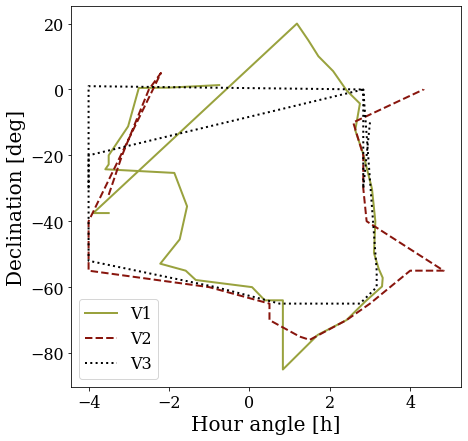

In [20]:
plt.plot(limits_v1_ha, limits_v1_dec, label='V1', linestyle='-')
plt.plot(limits_v2_ha, limits_v2_dec, label='V2', linestyle='--')
plt.plot(limits_v3_ha, limits_v3_dec, label='V3', linestyle=':')
plt.legend()
plt.xlabel('Hour angle [h]')
plt.ylabel('Declination [deg]')
plt.savefig('walops_constraints/plots/limits_all.png');

### Set contours

In a Monday telecon, Sid/Ram/Stephen clarified that we should use the contour of version 3 plus the lower extension given in version 1, which was not mapped out again in version 3. Below I define a polygon that roughly follows these outlines. Exact numbers need to be later confirmed of course.

In [21]:
polygon = [(-4, 0), (-4, -52), (0.8, -65), (0.8, -85), (1.7, -74.5), (2.4, -70.0), (3.2, -60), (2.8, 0)]

limits_final_ha = [x[0] for x in polygon] + [polygon[0][0]]
limits_final_dec = [x[1] for x in polygon] + [polygon[0][1]]

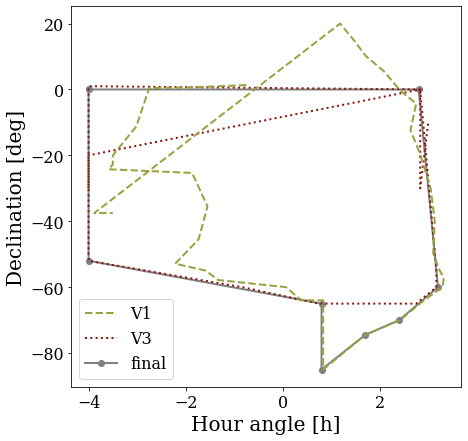

In [22]:
plt.plot(limits_v1_ha, limits_v1_dec, label='V1', linestyle='--', zorder=2)
plt.plot(limits_v3_ha, limits_v3_dec, label='V3', linestyle=':', zorder=1)
plt.plot(limits_final_ha, limits_final_dec, label='final', linestyle='-', color='0.5', marker='o', zorder=0)
plt.legend()
plt.xlabel('Hour angle [h]')
plt.ylabel('Declination [deg]')
plt.savefig('walops_constraints/plots/limits_all.png');

### Test constraint class with actual limits

In [23]:
constraint = PolyHADecLimit(polygon)

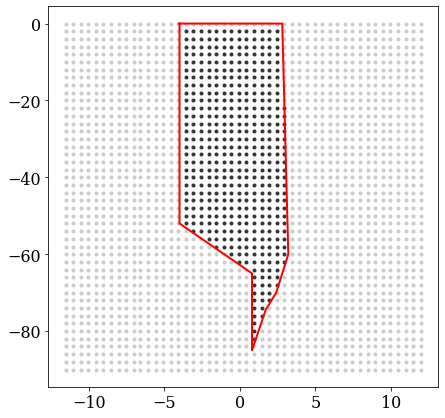

In [24]:
for dec in np.arange(-90, 1, 2):
    source_coord = SkyCoord('15:00:00', dec, unit=('hourangle', 'deg'))
    is_inside = constraint.get(source_coord, frame)
    hourangle = (source_coord.ra - lst).hourangle
    hourangle = (12. + hourangle) % 24. - 12.
    dec = np.ones(hourangle.size) * source_coord.dec.deg
    
    plt.plot(hourangle[is_inside], dec[is_inside], marker='o', ms=3, color='0.2', ls='None', zorder=0)
    plt.plot(hourangle[~is_inside], dec[~is_inside], marker='o', ms=3, color='0.8', ls='None', zorder=0)
    
polygon_ar = np.array(polygon + polygon[:1])
plt.plot(polygon_ar[:,0], polygon_ar[:,1], linestyle='-', color='r', zorder=1);

In [25]:
print(constraint)

Polygon Hourangle-Declination limits:
HA (h) Dec (deg)
 -4.00  +0.00
 -4.00 -52.00
 +0.80 -65.00
 +0.80 -85.00
 +1.70 -74.50
 +2.40 -70.00
 +3.20 -60.00
 +2.80  +0.00

